In [97]:
import numpy as np
import scipy.stats as stat
import matplotlib.pyplot as plot
import statsmodels.api as sm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn import linear_model
from copy import deepcopy 
from __future__ import print_function

np.set_printoptions(precision=4,suppress=True)


In [98]:
def print(*args):
    __builtins__.print(*("%.4f" % a if isinstance(a, float) else a
                         for a in args))

# Data setup and fitting

In [122]:
X = np.loadtxt("X.txt")
y = np.loadtxt("Y_30.txt")
n = np.shape(y)[0]
m = np.shape(X)[1]
print(X0)
print(y)

[[252.36  96.67   8.37]
 [262.54 100.07   9.07]
 [285.7   96.78   9.35]
 [277.52 101.3    9.67]
 [307.95 100.35   9.45]
 [322.44 104.8   10.12]
 [334.88 106.17  10.35]
 [350.11 109.2   11.03]
 [346.1  104.48  10.38]
 [374.91 106.88  12.15]
 [378.49 113.14  12.98]
 [397.48 112.38  11.34]
 [378.39 109.07  10.95]
 [393.44 114.45  12.89]
 [403.84 115.23  13.71]]
[146.0114 149.2133 160.5137 160.6265 171.7838 176.6336 184.9674 191.3625
 186.405  207.6233 217.232  213.2748 205.9927 219.1627 229.6404]


In [123]:
np.shape(X)[0]

15

In [4]:
clf = linear_model.LinearRegression()
clf.fit(X0,y)
beta_sk = np.append(clf.coef_ ,clf.intercept_)
beta_sk

LinearRegression()

In [61]:
beta = np.linalg.solve(X.T @ X, X.T @ y)
beta

array([0.3593081 , 0.02721588, 5.64110623, 2.93648719])

In [19]:
y_pred = X @ beta
e = y - y_pred
Q = e.T @ e
print(f"residuals: {y_pred - y}")
print(f"sum of squares of residuals: {Q}")

residuals: [-2.55288383  1.94428093  0.45537596 -0.66837452 -2.1588476   2.09840853
 -0.43088857  2.56469008  2.28626663  1.46970901 -2.00027845 -0.49183599
 -2.35904352  0.96872082 -1.12529949]
sum of squares of residuals: 46.17865892839897


In [20]:
s2 = Q / (n-m)
print(f"y variation estimate: {s2}") 

y variation estimate: 4.198059902581725


In [29]:
beta_cov = s2 * np.linalg.inv(X.T @ X)
beta_std = beta_cov.diagonal()**0.5
print(f"alpha covariance matrix estimate:\n{beta_cov}\n") 
print(f"alpha standard deviation estimate: {beta_std}")

alpha covariance matrix estimate:
[[ 1.02540972e-03 -5.89778391e-03 -8.58399381e-03  3.71819592e-01]
 [-5.89778391e-03  9.18925515e-02 -1.61932382e-01 -6.00779706e+00]
 [-8.58399381e-03 -1.61932382e-01  9.62992036e-01  9.68637468e+00]
 [ 3.71819592e-01 -6.00779706e+00  9.68637468e+00  4.07425123e+02]]

alpha standard deviation estimate: [ 0.03202202  0.30313784  0.98132158 20.18477453]


In [15]:
beta_cor = np.zeros((m,m))
for i in range(m):
    for j in range(m):
        beta_cor[i][j] = beta_cov[i][j] / (beta_std[i] * beta_std[j])
print(f"alpha correlation matrix estimate:\n {beta_cor}")

alpha correlation matrix estimate:
 [[ 1.         -0.60757513 -0.27316769  0.57525401]
 [-0.60757513  1.         -0.54435498 -0.98186368]
 [-0.27316769 -0.54435498  1.          0.48901932]
 [ 0.57525401 -0.98186368  0.48901932  1.        ]]


Text(0.5, 0, '$e_i$')

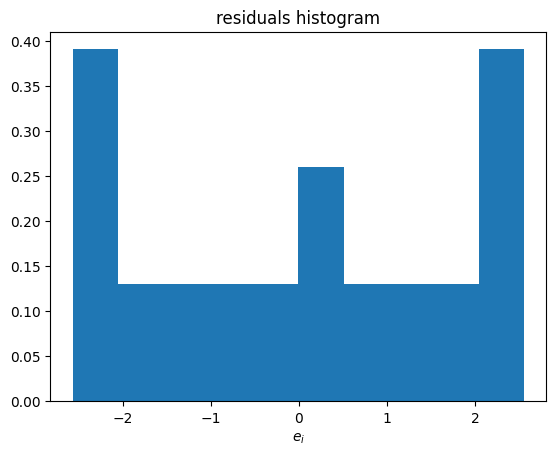

In [94]:
plot.hist(e,density=True,bins=10)
plot.title("residuals histogram")
plot.xlabel(r"$e_i$")

Text(0, 0.5, '$y$')

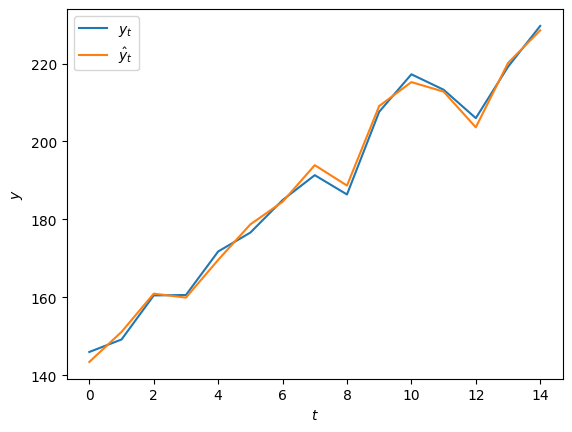

In [88]:
t = np.array([range(n)]).T
plot.plot(t,y,t,y_pred)
plot.legend([r"$y_t$",r"$\hat{y}_t$"])
plot.xlabel(r"$t$")
plot.ylabel(r"$y$")

In [27]:
R2 = 1 - Q / np.sum((y-y.mean())**2)
R2_unbiased = 1 - (Q / (n - m)) / (np.sum((y-y.mean())**2) / (n - 1))
print(f"R2 coef:{R2}")
print(f"unbiased R2 coef:{R2_unbiased}")


R2 coef:0.9954254192804067
unbiased R2 coef:0.9941778063568812


coefficient of determination R2 is really close to 1 -> model is much better than model only w/ constant term

# Hypotheses for regressions

In [31]:
alpha = 0.05 # level of significance, 1-alpha is confidence level
gamma = 1 - alpha

## individual confidence intervals

In [99]:
stud_quant = stat.t.ppf((1 + gamma)/2, n - m)
print(f"individual confidence intervals w/ confidence level {gamma}")
for i, beta_i in enumerate(beta):
    lb = beta_i - beta_std[i]*stud_quant
    ub = beta_i + beta_std[i]*stud_quant
    print(f"i = {i}; [{lb},{ub}]; {beta_i}")


individual confidence intervals w/ confidence level 0.95
i = 0; [0.28882810718551744,0.42978808550336756]; 0.3593080963444425
i = 1; [-0.6399860172996578,0.6944177676588134]; 0.02721587517957781
i = 2; [3.481232002297637,7.800980455653588]; 5.641106228975612
i = 3; [-41.48990200123047,47.362876382511296]; 2.9364871906404133


## joint confidence interval

In [42]:
# from tukey joint confidence interval
alpha_joint = alpha
gamma_joint = 1 - alpha_joint
gamma = 1 - alpha_joint / m
stud_quant = stat.t.ppf((1 + gamma)/2, n - m)
print(f"joint confidence interval w/ confidence level {gamma_joint}")
for i, beta_i in enumerate(beta):
    lb = beta_i - beta_std[i]*stud_quant
    ub = beta_i + beta_std[i]*stud_quant
    print(f"i = {i}; [{lb},{ub}]; {beta_i}")


joint confidence interval w/ confidence level 0.95
i = 0; [0.26385454205507464,0.4547616506340575]; 0.35930809634456606
i = 1; [-0.8763993612290677,0.9308311115853098]; 0.027215875178121074
i = 2; [2.7159117984023258,8.566300659552484]; 5.641106228977405
i = 3; [-57.231750676756185,63.104725058223956]; 2.936487190733885


# test for regressor's insignificance

In [62]:
# hypothesis for regressor insignificance (beta_i = 0)
alpha = 0.05
gamma = 1 - alpha
print("p value for H0 = {beta_i = 0}")
for i, beta_i in enumerate(beta):
    stat_val = np.abs(beta_i)/beta_std[i]
    p_value = 2*(1 - stat.t.cdf(stat_val, n - m))
    print(f"i={i}; p_value: {p_value}")

p value for H0 = {beta_i = 0}
i=0; p_value: 2.3125049541938836e-07
i=1; p_value: 0.9300754988795108
i=2; p_value: 0.00012865825526642283
i=3; p_value: 0.8869632328205976


second p-value is really small -> second regressor is insignificant and can be dropped out (as well as forth)

array([0.3593, 0.    , 5.6411, 2.9365])

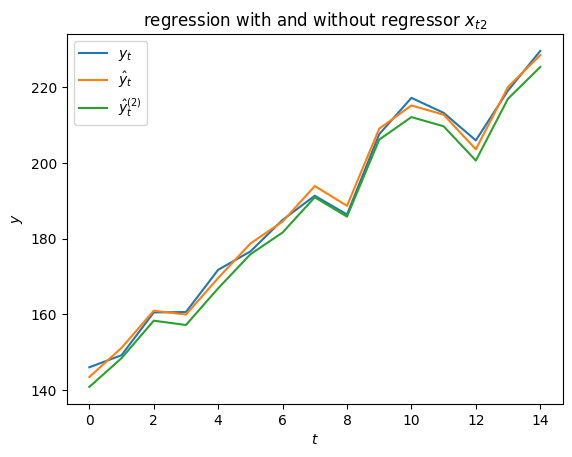

In [112]:
beta_mod = deepcopy(beta)
beta_mod[1] = 0
y_pred_mod = X @ beta_mod
t = np.array([range(n)]).T
plot.plot(t,y,t,y_pred,t,y_pred_mod)
plot.legend([r"$y_t$",r"$\hat{y}_t$", r"$\hat{y}_t^{(2)}$"])
plot.xlabel(r"$t$")
plot.ylabel(r"$y$")
plot.title(r"regression with and without regressor $x_{t2}$")
beta_mod

array([0.3593, 0.0272, 5.6411, 0.    ])

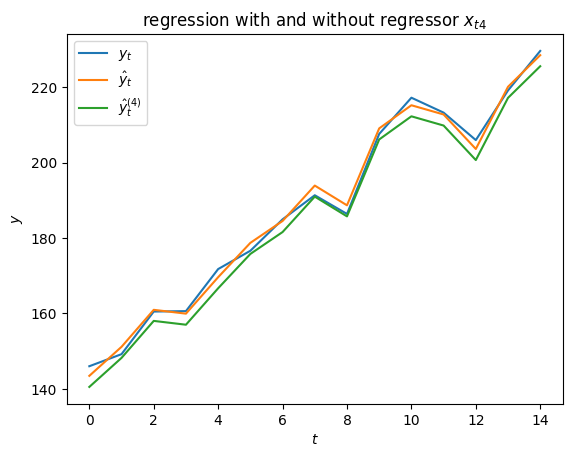

In [113]:
beta_mod = deepcopy(beta)
beta_mod[3] = 0
y_pred_mod = X @ beta_mod
t = np.array([range(n)]).T
plot.plot(t,y,t,y_pred,t,y_pred_mod)
plot.legend([r"$y_t$",r"$\hat{y}_t$", r"$\hat{y}_t^{(4)}$"])
plot.xlabel(r"$t$")
plot.ylabel(r"$y$")
plot.title(r"regression with and without regressor $x_{t4}$")
beta_mod

## test for fitness of model of average

In [72]:
# hypothesis for beta_i=0, i != m
stat_val = R2/(1-R2) * (n-m)/(m-1)
p_value = 1 - stat.f.cdf(stat_val, m - 1, n - m)
print(p_value)

3.816946758661288e-13


it's extremely unlikely that beta_i = 0 for all i != m

## test for regressions' equality 

0.4296
[ 0.435   0.2332  1.6647 -1.3471]
[  0.3854   0.2187   5.2242 -23.1101]
8.1983 20.2373 46.1787


Text(0.5, 1.0, 'regression, trained only on 5 first entries')

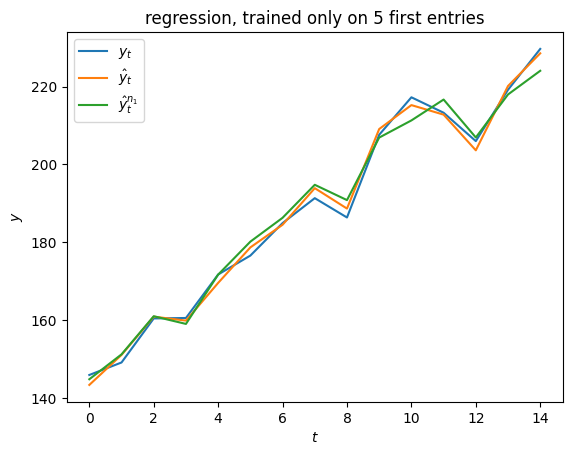

In [115]:
n1 = 5 # n1, n2 must be greater than m
n2 = n - n1
y1 = y[:n1]
y2 = y[n1:]
X1 = X[:n1,:]
X2 = X[n1:,:]

beta1 = np.linalg.solve(X1.T @ X1, X1.T @ y1)
beta2 = np.linalg.solve(X2.T @ X2, X2.T @ y2)
beta = np.linalg.solve(X.T @ X, X.T @ y)

Q_R = (y - X @ beta).T @ (y - X @ beta)
Q_1 = (y1 - X1 @ beta1).T @ (y1 - X1 @ beta1)
Q_2 = (y2 - X2 @ beta2).T @ (y2 - X2 @ beta2)
stat_val =( (Q_R - Q_1 - Q_2)/m) / ((Q_1 + Q_2)/(n1+n2-2*m))
p_value = 1 - stat.f.cdf(stat_val, m , n1 + n2 - 2*m)
print(p_value)
print(beta1)
print(beta2)
print(Q_1, Q_2, Q_R)

beta_mod = beta1
y_pred_mod = X @ beta_mod
t = np.array([range(n)]).T
plot.plot(t,y,t,y_pred,t,y_pred_mod)
plot.legend(["true","predicted", f"predicted with only {n1} entries"])

plot.legend([r"$y_t$",r"$\hat{y}_t$", r"$\hat{y}_t^{n_1}$"])
plot.xlabel(r"$t$")
plot.ylabel(r"$y$")
plot.title(r"regression, trained only on 5 first entries")

0.4296
[ 0.435   0.2332  1.6647 -1.3471]
[  0.3854   0.2187   5.2242 -23.1101]
8.1983 20.2373 46.1787


Text(0.5, 1.0, 'regression, trained only on 10 last entries')

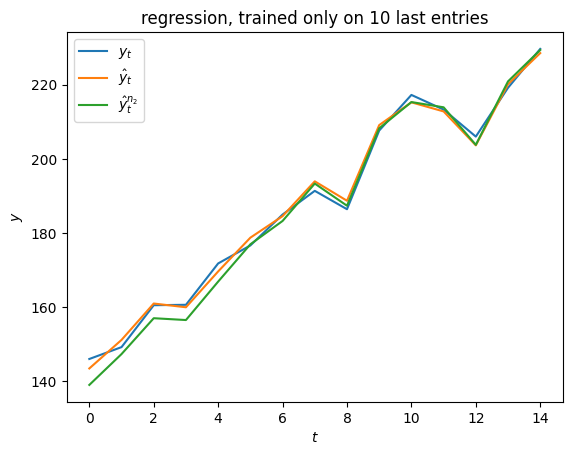

In [116]:
beta_mod = beta2
y_pred_mod = X @ beta_mod
t = np.array([range(n)]).T
plot.plot(t,y,t,y_pred,t,y_pred_mod)
plot.legend(["true","predicted", f"predicted with only {n1} entries"])

plot.legend([r"$y_t$",r"$\hat{y}_t$", r"$\hat{y}_t^{n_2}$"])
plot.xlabel(r"$t$")
plot.ylabel(r"$y$")
plot.title(r"regression, trained only on 10 last entries")

## prediction for test data

In [133]:
y = np.loadtxt("Y_30.txt")
X = np.loadtxt("X.txt")

y = y[1:]
X = X[1:,:]

n = np.shape(y)[0]
m = np.shape(X)[1]

beta = np.linalg.solve(X.T @ X, X.T @ y)

y_pred = X[0,:] @ beta
print(y_pred)
print(f"residue: {(y[0] - y_pred)}")
print(f"relative residue: {(y[0] - y_pred)/y[0]} ")

150.2638
residue: -1.0505158910340526
relative residue: -0.007040364577697459 
